In [48]:
import pandas as pd
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors 

In [49]:
df_data = pd.read_csv('data.csv', index_col=0).drop(columns=['Unnamed: 0'])
df_bac = pd.read_csv('bacterial_descriptors.csv', index_col=0)
df_drug = pd.read_csv('drug_descriptors.csv', index_col=0)

In [25]:
df_data.head(1)

,Bacteria,NP_Synthesis,Drug,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check
0,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,NaN,NaN,4.0,10.0,8.0,spherical,MIC,32+,6.3,32+,NaN,1


In [26]:
df_drug.head(1)

,drug,chemID,prefered_name,smiles
0,Amoxicillin,CHEMBL1082,AMOXICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...


In [27]:
Neomycin = {'drug': 'Neomycin', 'chemID': ''}
df_drug.append()

TypeError: append() missing 1 required positional argument: 'other'

In [28]:
'''
TODO TODO:
грамполож True False
is_bacteria T|F 
За-one-hot-encoditь clade phylum class order family genus,, кроме SPECIES
выкинуть минимум и максимум
проверить тип growth temp

'''

'\nTODO TODO:\nграмполож True False\nis_bacteria T|F \nЗа-one-hot-encoditь clade phylum class order family genus,, кроме SPECIES\nвыкинуть минимум и максимум\nпроверить тип growth temp\n\n'

In [29]:
df_bac.head(1)
df.

SyntaxError: invalid syntax (68732502.py, line 2)

In [30]:
df_bac.isolated_from.unique()

array(['urine', 'lungs', 'food', 'soil', 'mouth', 'blood', 'water', 'ear',
       'respiratory tract', 'sputum', 'intestinal tract', 'meat', 'skin',
       'nose', 'carious dentine', 'mammary gland', 'wood'], dtype=object)

<Axes: xlabel='biosafety_level', ylabel='Count'>

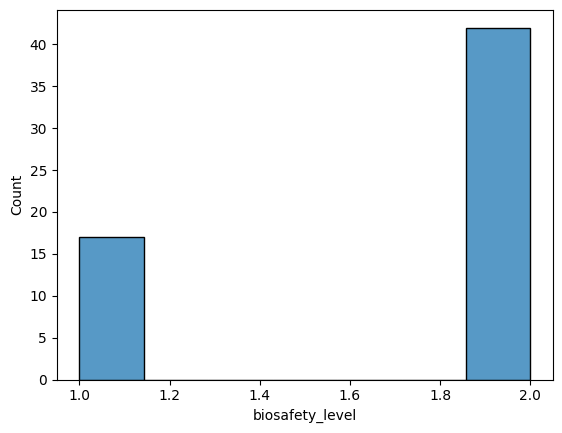

In [31]:
sns.histplot(df_bac['biosafety_level'])

In [32]:
df_bac.clade.unique()

array([nan, 'Opisthokonta', 'Terrabacteria group'], dtype=object)

In [50]:
df_drug.head(1)

,drug,chemID,prefered_name,smiles
0,Amoxicillin,CHEMBL1082,AMOXICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...


In [34]:
df_drug.ap

AttributeError: 'DataFrame' object has no attribute 'ap'

In [35]:
data_with_bac = pd.merge(df_data, df_bac, left_on='Bacteria', right_on='Bacteria', how='outer')

In [36]:
data_with_bac.head(1)

,Bacteria,NP_Synthesis,Drug,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,...,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from
0,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,NaN,NaN,4.0,10.0,8.0,spherical,...,Enterobacteriaceae,Escherichia,Escherichia coli,n,48.0,84.0,120.0,37.0,2.0,urine


In [37]:
data_with_bac.Drug.unique()

array(['Amoxicillin', 'Penicillin', 'Azithromycin', 'Cefuroxime',
       'Co-trimoxazole', 'Chloramphenicol', 'Cefotaxime', 'Neomycin',
       'Fosfomycin', 'Gentamicin', 'Ampicillin', 'Ceftazidime',
       'cefazolin', 'Cefixime ', 'Tetracycline', 'Amikacin',
       'Carbenicillin ', 'Streptomycin', 'Nalidixic acid', 'mupirocin',
       'Nitrofurantoin', 'Imipenem', 'Oxytetracycline', 'Vancomycin',
       'Oxacillin', 'Faropenem', 'Trimethoprim', 'Kanamycin',
       'Erythromycin', 'Cefepime', 'Ceftriaxone', 'Piperacillin',
       'Rifampicin', 'Cephalexin ', 'ciprofloxacin', 'Doxycycline',
       'Clindamycin ', 'Polymyxin', 'colistin ', 'Levofloxacin',
       'Biapenem', 'Aztreonam', nan, 'Fusidic acid ', 'Ciprofloxacin',
       'Amphotericin B'], dtype=object)

# Adding descriptors

In [44]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import pandas as pd
from pandas import DataFrame

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors 


def add_desc_to_df(df: DataFrame, desc: list):
    calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc)
    desc_df = pd.DataFrame(
        df['smiles'].map(lambda x: calc.CalcDescriptors(Chem.MolFromSmiles(x))).to_list()
    )
    desc_df.columns = desc
    return df.join(desc_df)


def fill_nan_desc(df: DataFrame, non_desc_cols: list = None):
    '''
    Fill NaN with calculated descriptors

    Parameters
    ----------
    df: DataFrame

    non_desc_cols: columns from df cant be calculated via rdkit 
    '''
    cols_to_drop = ['SMILES']
    cols_to_drop.extend(non_desc_cols)
    for col in df.drop(columns=cols_to_drop).columns:
        col_type = df[col].dtype
        calc = MoleculeDescriptors.MolecularDescriptorCalculator([col])
        mask = df[col].isna()
        df.loc[mask, col] = df.loc[mask, 'SMILES'].map(
            lambda x: calc.CalcDescriptors(Chem.MolFromSmiles(x))[0]
        ).astype(col_type)
    return df

In [53]:
descs_to_add = ['LabuteASA', 'NumHDonors', 'NumHAcceptors', 
                'MolLogP',
                'Solubility', 'MolWt']

In [45]:
df_drug = add_desc_to_df(df_drug, descs_to_add)

In [46]:
df_drug

,drug,chemID,prefered_name,smiles,LabuteASA,NumHDonors
0,Amoxicillin,CHEMBL1082,AMOXICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,147.914892,4
1,Penicillin,CHEMBL1223,PENICILLIN G POTASSIUM,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,186.703333,1
2,Vancomycin,CHEMBL262777,VANCOMYCIN,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,583.819675,19
3,Gentamicin,CHEMBL463809,GENTAMICIN C1,CN[C@@H]1[C@@H](O)[C@@H](O[C@@H]2[C@@H](O)[C@H...,194.976878,8
4,Ceftazidime,CHEMBL44354,CEFTAZIDIME,CC(C)(O/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=...,218.156211,3
5,Ampicillin,CHEMBL174,AMPICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=...,143.120659,3
6,Faropenem,CHEMBL556262,FAROPENEM,C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C([C@H]3CCCO3...,113.954518,2
7,Ceftriaxone,CHEMBL161,CEFTRIAXONE,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(CSc3nc...,213.957186,4
8,Rifampicin,CHEMBL374478,RIFAMPIN,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C...,343.914759,6
9,Azithromycin,CHEMBL529,AZITHROMYCIN,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,311.558245,5


In [20]:
drugs_in_drugs = set(df_drug.drug.unique())
drugs_in_drugs

{'Amikacin',
 'Amoxicillin',
 'Amphotericin B',
 'Ampicillin',
 'Azithromycin',
 'Aztreonam',
 'Biapenem',
 'Carbenicillin ',
 'Cefepime',
 'Cefixime ',
 'Cefotaxime',
 'Ceftazidime',
 'Ceftriaxone',
 'Cefuroxime',
 'Cephalexin ',
 'Chloramphenicol',
 'Ciprofloxacin',
 'Clindamycin ',
 'Co-trimoxazole',
 'Doxycycline',
 'Erythromycin',
 'Faropenem',
 'Fosfomycin',
 'Fusidic acid ',
 'Gentamicin',
 'Imipenem',
 'Kanamycin',
 'Levofloxacin',
 'Nalidixic acid',
 'Nitrofurantoin',
 'Oxacillin',
 'Oxytetracycline',
 'Penicillin',
 'Piperacillin',
 'Polymyxin',
 'Rifampicin',
 'Streptomycin',
 'Tetracycline',
 'Trimethoprim',
 'Vancomycin',
 'cefazolin',
 'ciprofloxacin',
 'colistin ',
 'mupirocin'}

In [21]:
drugs_in_data = set(data_with_bac.Drug.unique())
drugs_in_data

{'Amikacin',
 'Amoxicillin',
 'Amphotericin B',
 'Ampicillin',
 'Azithromycin',
 'Aztreonam',
 'Biapenem',
 'Carbenicillin ',
 'Cefepime',
 'Cefixime ',
 'Cefotaxime',
 'Ceftazidime',
 'Ceftriaxone',
 'Cefuroxime',
 'Cephalexin ',
 'Chloramphenicol',
 'Ciprofloxacin',
 'Clindamycin ',
 'Co-trimoxazole',
 'Doxycycline',
 'Erythromycin',
 'Faropenem',
 'Fosfomycin',
 'Fusidic acid ',
 'Gentamicin',
 'Imipenem',
 'Kanamycin',
 'Levofloxacin',
 'Nalidixic acid',
 'Neomycin',
 'Nitrofurantoin',
 'Oxacillin',
 'Oxytetracycline',
 'Penicillin',
 'Piperacillin',
 'Polymyxin',
 'Rifampicin',
 'Streptomycin',
 'Tetracycline',
 'Trimethoprim',
 'Vancomycin',
 'cefazolin',
 'ciprofloxacin',
 'colistin ',
 'mupirocin',
 nan}

In [19]:
drugs_in_data.difference(drugs_in_drugs) # need to add

{'Neomycin', nan}

In [ ]:
{}

In [ ]:
df_drug.append()

In [ ]:
df = pd.merge(data_with_bac, df_drug, left='Drug')